In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from Chempy.parameter import ModelParameters

import sbi.utils as utils
from sbi.utils.user_input_checks import check_sbi_inputs, process_prior, process_simulator
from sbi.inference import NPE, simulate_for_sbi, NPE_C
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp
from sbi.neural_nets import posterior_nn

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle
import os
from tqdm import tqdm

from plot_functions import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# ----- Config -------------------------------------------------------------------------------------------------------------------------------------------

name = "NPE_C"

# ----- Load the model -------------------------------------------------------------------------------------------------------------------------------------------
# --- Define the prior ---
a = ModelParameters()
labels_out = a.elements_to_trace
labels_in = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)


# --- Set up the model ---
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels_in), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(labels_out))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x

model = Model_Torch()

# --- Load the weights ---
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.eval()

/tmp/ipykernel_1499103/2751798252.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))


Model_Torch(
  (l1): Linear(in_features=6, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=40, bias=True)
  (l3): Linear(in_features=40, out_features=9, bias=True)
)

In [3]:
# ----- Load posterior -----
with open(f'data/posterior_{name}.pickle', 'rb') as f:
    posterior = pickle.load(f)

/export/home/bguenes/envs/master_chempy_multi/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b

In [16]:
# --- Simulation based calibration plot ---

def simulator(params):
    y = model(params)
    y = y.detach().numpy()

    # Remove H from data, because it is just used for normalization (output with index 2)
    y = np.delete(y, 2,1)

    return y

num_sbc_samples = 200  # choose a number of sbc runs, should be ~100s
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = combined_priors.sample((num_sbc_samples,))
xs = simulator(thetas)

In [17]:
import math
from typing import Callable, Optional

import torch

from sbi.sbi_types import Shape

class DispersedPosterior:
    def __init__(self, posterior: Callable, dispersion: float = 1.05):
        """give me a posterior and I'll disperse it. All calls to `sample` are wrapped.
        This class exploits: Var(aX) = a**2 * Var(X) for any random variable X
        while retaining the expectation value E[X] of all samples.

        Parameters:
            posterior: posterior distribution modelled like NeuralPosterior
            dispersion: choose values <1. to make the variance smaller,
                choose values >1. to make the variance larger (distribution more wide)
        """

        self.dispersion = math.sqrt(dispersion)
        self.posterior = posterior

    def set_default_x(self, x):
        self.posterior.set_default_x(x)

    def sample(
        self,
        sample_shape: Shape,
        x: Optional[torch.Tensor] = None,
        show_progress_bars: bool = False,
    ):
        value = self.posterior.sample(
            sample_shape, x, show_progress_bars=show_progress_bars
        )

        # obtain the median of all samples before applying
        # the dispersion to them (use median for more robust estimate)
        median = torch.median(value, dim=0)  # dim 0 is the batch dimension

        # disperse the samples
        dispersed = value * self.dispersion

        # obtain the new median after the dispersion
        median_ = torch.median(dispersed, dim=0)

        # shift to obtain the original expectation values
        # (we only want to disperse the samples, not offset)
        shift = median.values - median_.values

        return dispersed + shift

    def sample_batched(
        self,
        sample_shape: Shape,
        x: Optional[torch.Tensor] = None,
        show_progress_bars: bool = False,
    ):
        value = self.posterior.sample_batched(
            sample_shape, x, show_progress_bars=show_progress_bars
        )

        # obtain the median of all samples before applying
        # the dispersion to them (use median for more robust estimate)
        median = torch.median(value, dim=0)

        # disperse the samples
        dispersed = value * self.dispersion

        # obtain the new median after the dispersion
        median_ = torch.median(dispersed, dim=0)

        # shift to obtain the original expectation values
        # (we only want to disperse the samples, not offset)
        shift = median.values - median_.values

        return dispersed + shift

In [46]:
posterior_dispersed = DispersedPosterior(posterior, dispersion=0.5)
with open(f'data/posterior_{name}.pickle', 'wb') as f:
    pickle.dump(posterior_dispersed, f)

In [47]:
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior_dispersed, num_posterior_samples=num_posterior_samples
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 200 sbc samples.:   0%|          | 0/200 [00:00<?, ?it/s]

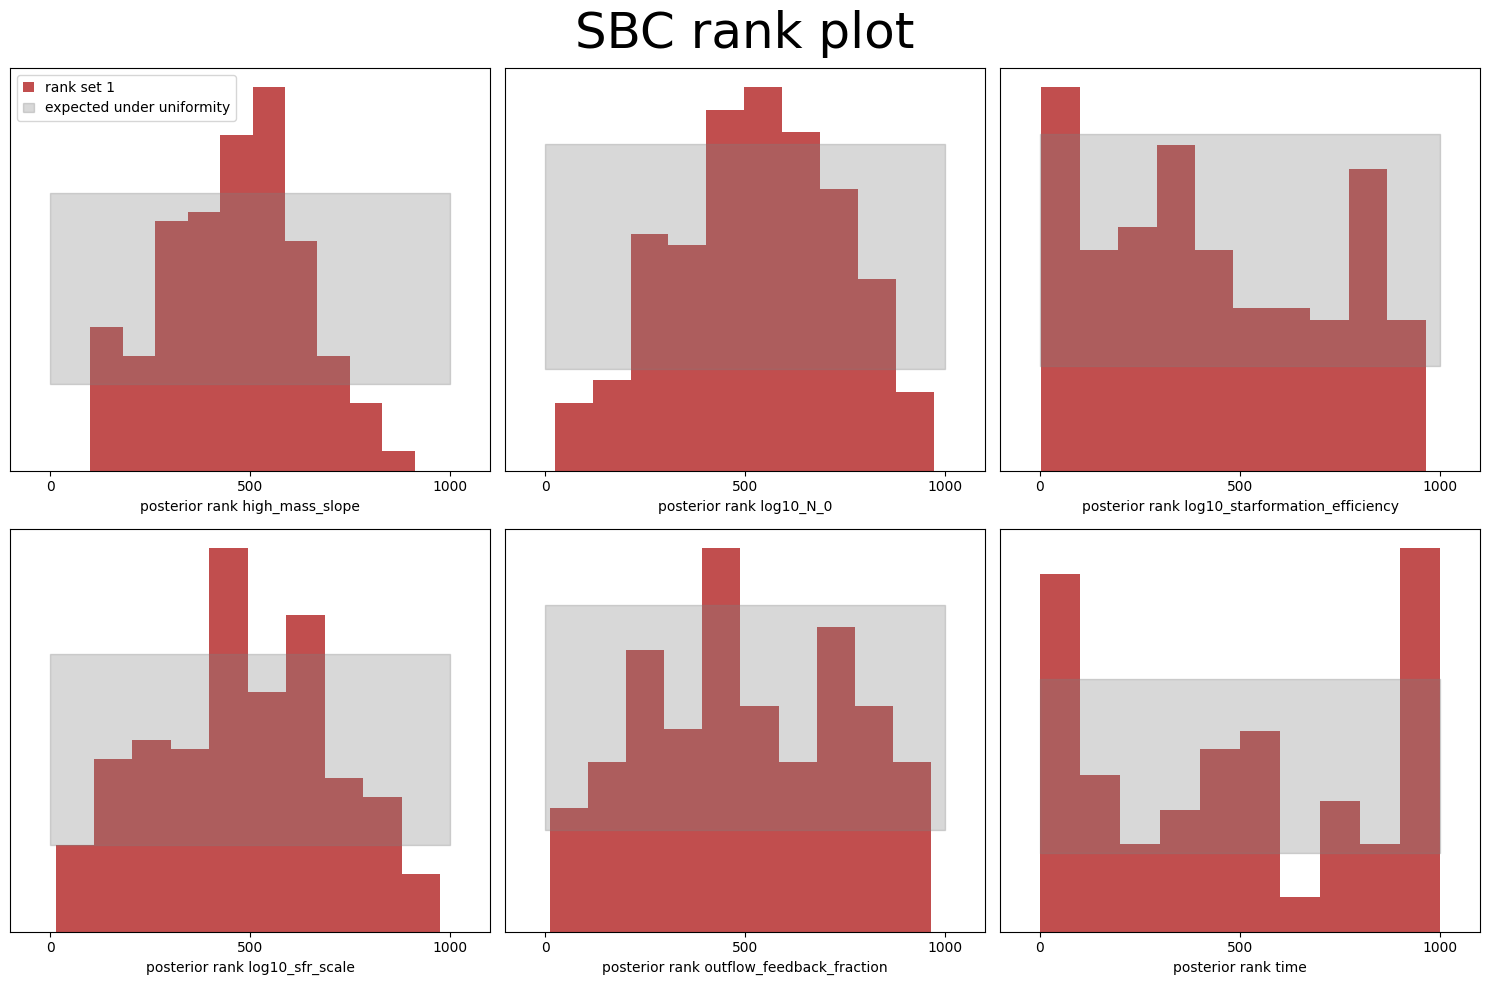

In [48]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    parameter_labels=labels_in,
    plot_type="hist",
    num_cols=3,
    figsize=(15,10),
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

f.suptitle("SBC rank plot", fontsize=36)
plt.tight_layout()

In [49]:
# the tarp method returns the ECP values for a given set of alpha coverage levels.
ecp, alpha = run_tarp(
    thetas,
    xs,
    posterior_dispersed,
    references=None,  # will be calculated automatically.
    num_posterior_samples=1000,
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [44]:
# Similar to SBC, we can check then check whether the distribution of ecp is close to
# that of alpha.
atc, ks_pval = check_tarp(ecp, alpha)
print(atc, "Should be close to 0")
print(ks_pval, "Should be larger than 0.05")

-0.021001756191253662 Should be close to 0
0.9634297148886908 Should be larger than 0.05


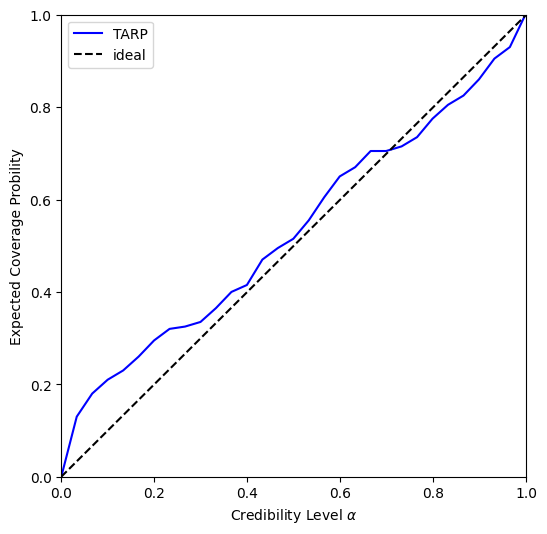

In [45]:
# Or, we can perform a visual check.
from sbi.analysis.plot import plot_tarp
plot_tarp(ecp, alpha);

In [12]:
# ----- Evaluate the posterior -------------------------------------------------------------------------------------------------------------------------------------------
# --- Load the validation data ---
# Validation data created with CHEMPY, not with the NN simulator
print("Evaluating the posterior...")
path_test = 'data/chempy_data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_theta = val_data['params']
val_x = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y

val_theta, val_x = clean_data(val_theta, val_x)

# convert to torch tensors
val_theta = torch.tensor(val_theta, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
abundances =  torch.cat([val_x[:,:2], val_x[:,3:]], dim=1)

# add noise to data to simulate observational errors
pc_ab = 5 # percentage error in abundance
x_err = np.ones_like(abundances)*float(pc_ab)/100.
abundances = norm.rvs(loc=abundances,scale=x_err)
abundances = torch.tensor(abundances).float()

theta_hat = torch.zeros_like(val_theta)
for index in tqdm(range(len(abundances))):
    thetas_predicted = posterior_dispersed.sample((1000,), x=abundances[index], show_progress_bars=False)
    theta_predicted = thetas_predicted.mean(dim=0)
    theta_hat[index] = theta_predicted

ape = torch.abs((val_theta - theta_hat) / val_theta) *100

# --- Absolute percentage error plot ---
save_path = None
ape_plot(ape, labels_in, save_path)


Evaluating the posterior...


  2%|▏         | 809/49824 [00:08<08:07, 100.49it/s]


KeyboardInterrupt: 